## Non Intrusive Load Monitoring (NILM) 

Smart meter data can be used to predict which appliances are turned on in a household. The following code is an implementation of NILM to predict which appliances are turned on/off applied on the 2014 ECO dataset from ETCH Zurich. For simiplicity, only a sample from household 1 is considered. Occupancy data and date/time/season based analysis is not considered in the development of this model. The smart meter data is directly used while the plugs data is converted to binary with 1 meaning on and 0 meaning off. 

### Imports and preparations

In [1]:
# list of imports
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    classification_report,
    f1_score,
    multilabel_confusion_matrix,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

import src  # custom source code that has a lot of useful functions 

#### Downloading the dataset

The data should be downloaded from the following link:- https://app.data-archive.ethz.ch/delivery/DeliveryManagerServlet?dps_pid=IE594964

### Initial Preprocessing and Analysis

Configurations

In [2]:
# select household (id: 1-6)
household_id = 1

In [3]:
# using json files for a simpler loading of the dataset
dataset = src.read_json("Dataset/dataset.json") 
household = src.read_json(f"Dataset/{dataset['files'][f'household_{household_id}']}")

In [4]:
dataset # dataset has the folder paths for the households

{'description': 'Index of ECO dataset household metadata JSON files',
 'dataset': 'ECO',
 'files': {'household_1': 'house_1/house_1.json',
  'household_2': 'house_2/house_2.json',
  'household_3': 'house_3/house_3.json',
  'household_4': 'house_4/house_4.json',
  'household_5': 'house_5/house_5.json',
  'household_6': 'house_6/house_6.json'}}

In [5]:
household # household is a dict that has all the necessary details on the household # dataset

{'household_id': 1,
 'smart_meter_data': {'measurement_period': {'start_date': '2012-06-01',
   'end_date': '2013-01-31'},
  'days_recorded': 245,
  'coverage_percent': 99.64,
  'sampling_rate': '1 second',
  'rows_per_day': 86400,
  'missing_value_indicator': -1,
  'columns': ['powerallphases',
   'powerl1',
   'powerl2',
   'powerl3',
   'currentneutral',
   'currentl1',
   'currentl2',
   'currentl3',
   'voltagel1',
   'voltagel2',
   'voltagel3',
   'phaseanglevoltagel2l1',
   'phaseanglevoltagel3l1',
   'phaseanglecurrentvoltagel1',
   'phaseanglecurrentvoltagel2',
   'phaseanglecurrentvoltagel3']},
 'plug_data': {'measurement_period': {'start_date': '2012-06-01',
   'end_date': '2013-01-23'},
  'sampling_rate': '1 second',
  'rows_per_day': 86400,
  'columns': ['consumption'],
  'plugs': {'01': {'appliance': 'Fridge',
    'days_recorded': 231,
    'coverage_percent': 98.53},
   '02': {'appliance': 'Dryer',
    'days_recorded': 231,
    'coverage_percent': 98.56},
   '03': {'appl

In [6]:
plugs_columns = [household['plug_data']['plugs'][i]['appliance'] for i in household['plug_data']['plugs'].keys()]
plugs_columns # display the names of appliances for the respective household

['Fridge',
 'Dryer',
 'Coffee machine',
 'Kettle',
 'Washing machine',
 'PC (including router)',
 'Freezer']

In [7]:
sm_columns = household['smart_meter_data']['columns']
sm_columns # display the names of smart meter data columns

['powerallphases',
 'powerl1',
 'powerl2',
 'powerl3',
 'currentneutral',
 'currentl1',
 'currentl2',
 'currentl3',
 'voltagel1',
 'voltagel2',
 'voltagel3',
 'phaseanglevoltagel2l1',
 'phaseanglevoltagel3l1',
 'phaseanglecurrentvoltagel1',
 'phaseanglecurrentvoltagel2',
 'phaseanglecurrentvoltagel3']

In [8]:
path = f"Dataset/house_{household_id}/0{household_id}_sm"
sm_files = src.list_files(path) # list of all the smart meter data excel files, each file is for 1 day containing 86400 rows

In [9]:
len(sm_files) # this corresponds for a period of 8 months

245

Let's take a sample file for a single day for household-1. The date format is year-month-day

In [10]:
sm_file = sm_files[1]
sm_file

'2012-06-26.csv'

In [11]:
df_sm = pd.read_csv(f"{path}/{sm_file}", header=None, names=sm_columns) # read the csv file and pass the column names

In [12]:
df_sm.head(3)

,powerallphases,powerl1,powerl2,powerl3,currentneutral,currentl1,currentl2,currentl3,voltagel1,voltagel2,voltagel3,phaseanglevoltagel2l1,phaseanglevoltagel3l1,phaseanglecurrentvoltagel1,phaseanglecurrentvoltagel2,phaseanglecurrentvoltagel3
0,90,60,20,10,0.3,0.4,0.2,0.1,241.6,241,242,240,120,321,297,293
1,90,60,20,10,0.3,0.4,0.2,0.1,241.6,241,241,240,120,321,297,293
2,90,60,20,10,0.3,0.4,0.2,0.1,241.6,241,241,240,120,321,297,293


Then, we can find the corresponding plug data by referencing the date of the smart meter data. Household-1 has 7 classes (1-7).

In [13]:
df_plugs = pd.DataFrame(columns=plugs_columns)
path_plugs = f"Dataset/house_{household_id}/0{household_id}_plugs"
for i in range(1,8):
        plug_file = f"{path_plugs}/0{i}/{sm_file}"
        check = src.file_exists(plug_file) # check if the file is available for that date
        if check: 
            df_plug = pd.read_csv(plug_file, header=None, names=[plugs_columns[i-1]]) 
            df_sm[plugs_columns[i-1]] = df_plug[plugs_columns[i-1]]
        else:  
            df_sm[plugs_columns[i-1]] = np.nan # make it NAN if the file doesn't exist, we will see if we can fill it later 

Now df_sm contains a compilation of the smart meter data and the respective appliance data.

In [14]:
df_sm.head(3)

,powerallphases,powerl1,powerl2,powerl3,currentneutral,currentl1,currentl2,currentl3,voltagel1,voltagel2,...,phaseanglecurrentvoltagel1,phaseanglecurrentvoltagel2,phaseanglecurrentvoltagel3,Fridge,Dryer,Coffee machine,Kettle,Washing machine,PC (including router),Freezer
0,90,60,20,10,0.3,0.4,0.2,0.1,241.6,241,...,321,297,293,2.20578,0.0000,NaN,0.0,0.0,10.8824,32.4316
1,90,60,20,10,0.3,0.4,0.2,0.1,241.6,241,...,321,297,293,2.20578,2.1906,NaN,0.0,0.0,10.8824,32.4316
2,90,60,20,10,0.3,0.4,0.2,0.1,241.6,241,...,321,297,293,0.00000,0.0000,NaN,0.0,0.0,10.8824,32.4316


In [15]:
df_sm.isnull().any() # check if any of the columns have null values

powerallphases                False
powerl1                       False
powerl2                       False
powerl3                       False
currentneutral                False
currentl1                     False
currentl2                     False
currentl3                     False
voltagel1                     False
voltagel2                     False
voltagel3                     False
phaseanglevoltagel2l1         False
phaseanglevoltagel3l1         False
phaseanglecurrentvoltagel1    False
phaseanglecurrentvoltagel2    False
phaseanglecurrentvoltagel3    False
Fridge                        False
Dryer                         False
Coffee machine                 True
Kettle                        False
Washing machine               False
PC (including router)         False
Freezer                       False
dtype: bool

From the above, we can see that the Coffee machine has null values, while other columns don't have null values. 

We should examine if this column has a few null values or if it is empty throughout. For this specific example, I know that it is for all the column as the date chosen is in summer. The coffee machine doesn't have records in summer, and its existing records show that it is only available during winter. I will assume that it was off during the entire summer where I don't have records for it.

Additionally, the dataset authors indicated that rows with -1 have invalid data and thus we can remove them from our dataset.

In [16]:
df_sm['Coffee machine'].isnull().all() # check if the coffee machine column has all null values. 

True

In [17]:
df_cleaned = df_sm[~(df_sm == -1).any(axis=1)] # let's create a new dataframe that doesn't have the -1 values, which are used to indicate invalid data

In [18]:
df_cleaned = df_cleaned.fillna(0) # fill null values of the coffee machine with 0, as it is not available during summer

In [19]:
df_cleaned.head(3)

,powerallphases,powerl1,powerl2,powerl3,currentneutral,currentl1,currentl2,currentl3,voltagel1,voltagel2,...,phaseanglecurrentvoltagel1,phaseanglecurrentvoltagel2,phaseanglecurrentvoltagel3,Fridge,Dryer,Coffee machine,Kettle,Washing machine,PC (including router),Freezer
0,90,60,20,10,0.3,0.4,0.2,0.1,241.6,241,...,321,297,293,2.20578,0.0000,0.0,0.0,0.0,10.8824,32.4316
1,90,60,20,10,0.3,0.4,0.2,0.1,241.6,241,...,321,297,293,2.20578,2.1906,0.0,0.0,0.0,10.8824,32.4316
2,90,60,20,10,0.3,0.4,0.2,0.1,241.6,241,...,321,297,293,0.00000,0.0000,0.0,0.0,0.0,10.8824,32.4316


The next step is to apply thresholding to the plugs columns as we are going to build a multi-label classification model. Let's use the following function to map the values. 

In [20]:
def transform_appliance_value(x):
    if x == 0:
        return 0 # if it is off, return 0
    elif x > 1:
        return 1 # if it is on, return 1
    else:
        return np.nan # otherwise it is invalid, so return NaN

In [21]:
df_cleaned[plugs_columns] = df_cleaned[plugs_columns].map(transform_appliance_value) # apply the transformation to the plugs columns

In [22]:
df_cleaned.head(3)

,powerallphases,powerl1,powerl2,powerl3,currentneutral,currentl1,currentl2,currentl3,voltagel1,voltagel2,...,phaseanglecurrentvoltagel1,phaseanglecurrentvoltagel2,phaseanglecurrentvoltagel3,Fridge,Dryer,Coffee machine,Kettle,Washing machine,PC (including router),Freezer
0,90,60,20,10,0.3,0.4,0.2,0.1,241.6,241,...,321,297,293,1,0,0,0,0,1,1
1,90,60,20,10,0.3,0.4,0.2,0.1,241.6,241,...,321,297,293,1,1,0,0,0,1,1
2,90,60,20,10,0.3,0.4,0.2,0.1,241.6,241,...,321,297,293,0,0,0,0,0,1,1


In [23]:
df_cleaned.isnull().any() # check if any of the columns have null values after the transformation 

powerallphases                False
powerl1                       False
powerl2                       False
powerl3                       False
currentneutral                False
currentl1                     False
currentl2                     False
currentl3                     False
voltagel1                     False
voltagel2                     False
voltagel3                     False
phaseanglevoltagel2l1         False
phaseanglevoltagel3l1         False
phaseanglecurrentvoltagel1    False
phaseanglecurrentvoltagel2    False
phaseanglecurrentvoltagel3    False
Fridge                        False
Dryer                         False
Coffee machine                False
Kettle                        False
Washing machine               False
PC (including router)         False
Freezer                       False
dtype: bool

Now, in order to avoid **data leaks** from the training to the testing dataset, we should drop duplicated rows from our dataframe. Then, split the dataset and save it to training and testing sets. 

In [24]:
len(df_cleaned)

86400

In [25]:
df_cleaned.drop_duplicates(inplace=True) # drop duplicated rows to avoid data leaks from training to testing dataset

In [26]:
len(df_cleaned)

32438

In [27]:
df_cleaned # now this is the cleaned dataframe that we will use for training and testing our model 

,powerallphases,powerl1,powerl2,powerl3,currentneutral,currentl1,currentl2,currentl3,voltagel1,voltagel2,...,phaseanglecurrentvoltagel1,phaseanglecurrentvoltagel2,phaseanglecurrentvoltagel3,Fridge,Dryer,Coffee machine,Kettle,Washing machine,PC (including router),Freezer
0,90,60,20,10,0.3,0.4,0.2,0.1,241.6,241,...,321,297,293,1,0,0,0,0,1,1
1,90,60,20,10,0.3,0.4,0.2,0.1,241.6,241,...,321,297,293,1,1,0,0,0,1,1
2,90,60,20,10,0.3,0.4,0.2,0.1,241.6,241,...,321,297,293,0,0,0,0,0,1,1
3,90,60,20,10,0.3,0.4,0.2,0.1,241.6,241,...,321,296,293,1,0,0,0,0,1,1
5,90,60,20,10,0.3,0.4,0.2,0.1,241.5,241,...,321,297,293,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86384,60,30,20,10,0.3,0.4,0.2,0.1,239.1,239,...,294,297,292,0,0,0,0,1,1,0
86390,60,30,20,10,0.3,0.4,0.2,0.1,239.1,239,...,294,296,293,1,0,0,0,1,1,1
86396,60,30,20,10,0.3,0.4,0.2,0.1,239.1,239,...,294,297,292,1,1,0,0,1,1,0
86398,60,30,20,10,0.3,0.4,0.2,0.1,239.0,239,...,294,297,293,1,0,0,0,1,1,1


Let's save this processed dataframe before proceeding to the next step.

In [28]:
saving_path = f"Dataset/house_{household_id}/preprocessed_data"
src.make_dir_if_not_exists(saving_path) # we will save the data in this folder so we need to create it if it doesn't exist

In [29]:
df_cleaned.to_csv(f"{saving_path}/{sm_file}", index=False)  # save the cleaned dataframe to a csv file with the same name as the date of the data capture

Now we can split this data to training and testing set. I chose the ratio of 7:3 for the split.

In [30]:
train_df, test_df = train_test_split(df_cleaned, test_size=0.3, random_state=42, shuffle=True)

In [31]:
train_df.shape, test_df.shape # display the shape of the training and testing dataframes

((22706, 23), (9732, 23))

In [32]:
DATA_DIR = "dataset/house_1" # save the files to csv files in the dataset directory
train_df.to_csv(f'{DATA_DIR}/train_data.csv', index=False)
test_df.to_csv(f'{DATA_DIR}/test_data.csv', index=False)

This sampled data is extremely extremely tiny compared with the full dataset as it is just obtained from 1 day. The proper final model needs to be trained on a more robust sample as can be showed in the following tests for dataset imbalance. 

In [34]:
# checking for class imbalance
class_counts = df_cleaned[plugs_columns].value_counts()
print(class_counts / len(df_cleaned) * 100)

Fridge  Dryer  Coffee machine  Kettle  Washing machine  PC (including router)  Freezer
1       0      0               0       0                1                      1          53.434244
                                                                               0          12.830631
                                       1                1                      1          10.324311
0       0      0               0       0                1                      1           8.113940
1       1      0               0       0                1                      1           4.812257
0       0      0               0       1                1                      1           3.563722
1       0      0               0       1                1                      0           2.268944
0       0      0               0       0                1                      0           1.378013
                                       1                1                      0           0.767618
1       1    

From the above we can see that there is a huge dataset imbalance in where more than 53% of the output corresponds to sequence [1, 0, 0, 0, 0, 1, 1] indicating the ['Fridge','Dryer','Coffee machine','Kettle','Washing machine','PC (including router)','Freezer'] are on or off. This invalidates some classification metrics like the accuracy. Therefore, the focus should be on classification metrics that are blind to class imbalance like the mean average precision. 

### Model Development and Training

#### Imports and Configs

Up until this point we have the pre-processed sampled dataset ready for training. In this section, a custom model architecture is used to train a multi-label classification model.

In [35]:
# imports
import os

import fire
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    classification_report,
    f1_score,
    multilabel_confusion_matrix,
    precision_score,
    recall_score,
)
from sklearn.preprocessing import StandardScaler
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

import src

In [ ]:
# configurations
DATA_DIR = "dataset/house_1"
TRAIN_FILE = os.path.join(DATA_DIR, "train_data.csv")
TEST_FILE = os.path.join(DATA_DIR, "test_data.csv")
NO_EPOCHS = 30
MODEL_SAVE_PATH = f"models/eco_multilabel_model_e{NO_EPOCHS}.pth"
FEATURE_COLS = sm_columns
TARGET_COLS = plugs_columns

In [37]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

#### Custom Classes and Functions 

The following are the necessary classes and functions that we are going to use. I use a custom dataset, the default dataset loader, and a custom model architecture.

In [38]:
class EcoDataset(Dataset): # custom dataset class for loading the data from CSV files
    def __init__(
        self, csv_file, feature_cols, target_cols, scaler=None, fit_scaler=False
    ):
        self.df = pd.read_csv(csv_file)
        self.features = self.df[feature_cols].values.astype(np.float32)
        self.targets = self.df[target_cols].values.astype(np.float32)

        if scaler is None:
            self.scaler = StandardScaler()
            if fit_scaler:
                self.features = self.scaler.fit_transform(self.features)
            else:
                self.features = self.scaler.transform(self.features)
        else:
            self.scaler = scaler
            self.features = self.scaler.transform(self.features)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x = torch.tensor(self.features[idx])
        y = torch.tensor(self.targets[idx])
        return x, y

In [39]:
class MultiLabelClassifier(nn.Module): # custom model architecture for multi-label classification
    def __init__(self, input_dim, output_dim):
        super(MultiLabelClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, output_dim),
            # nn.Sigmoid()  # sigmoid for multilabel binary probs ##--removed here because I am using BCEWithLogitsLoss later on
        )

    def forward(self, x):
        return self.net(x)

In [40]:
def train_epoch(model, dataloader, criterion, optimizer): # training loop for one epoch
    model.train()
    running_loss = 0
    all_targets = []
    all_preds = []
    for x, y in tqdm(dataloader, desc="Training", leave=False):
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        raw_outputs = model(x)
        outputs = torch.sigmoid(raw_outputs)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        all_targets.append(y.detach().cpu().numpy())
        all_preds.append(outputs.detach().cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    all_targets = np.vstack(all_targets)
    all_preds = np.vstack(all_preds)
    f1, recall, precision, accuracy, mAP, _ = calculate_metrics(all_targets, all_preds)

    return epoch_loss, f1, recall, precision, accuracy, mAP

In [41]:
def test_epoch(model, dataloader, criterion): # testing loop for one epoch
    model.eval()
    running_loss = 0
    all_targets = []
    all_preds = []
    with torch.no_grad():
        for x, y in tqdm(dataloader, desc="Testing", leave=False):
            x, y = x.to(DEVICE), y.to(DEVICE)
            raw_outputs = model(x)
            outputs = torch.sigmoid(raw_outputs)

            loss = criterion(outputs, y)
            running_loss += loss.item() * x.size(0)

            all_targets.append(y.detach().cpu().numpy())
            all_preds.append(outputs.detach().cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    all_targets = np.vstack(all_targets)
    all_preds = np.vstack(all_preds)
    f1, recall, precision, accuracy, mAP, y_pred_bin = calculate_metrics(
        all_targets, all_preds
    )

    true_bin = all_targets.astype(int)
    pred_bin = y_pred_bin.astype(int)

    assert true_bin.shape == pred_bin.shape
    # print("\n=== Classification Report (Test) ===")
    # print(
    #     classification_report(
    #         true_bin, pred_bin, target_names=TARGET_COLS, zero_division=0
    #     )
    # )

    return epoch_loss, f1, recall, precision, accuracy, mAP

In [42]:
def calculate_metrics(y_true, y_pred, threshold=0.5):

    y_true = np.asarray(y_true, dtype=np.int32)
    y_pred = np.asarray(y_pred, dtype=np.float32)
    y_pred_bin = (y_pred >= threshold).astype(np.int32)

    if y_true.ndim == 1:
        y_true = y_true.reshape(-1, 1)
    if y_pred_bin.ndim == 1:
        y_pred_bin = y_pred_bin.reshape(-1, 1)
    if y_pred.ndim == 1:
        y_pred = y_pred.reshape(-1, 1)

    n_samples, n_labels = y_true.shape

    f1_scores = []
    recall_scores = []
    precision_scores = []

    for label_idx in range(n_labels):
        y_true_label = y_true[:, label_idx]
        y_pred_label = y_pred_bin[:, label_idx]

        tp = np.sum((y_true_label == 1) & (y_pred_label == 1))
        fp = np.sum((y_true_label == 0) & (y_pred_label == 1))
        fn = np.sum((y_true_label == 1) & (y_pred_label == 0))

        precision_label = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall_label = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_label = (
            2 * (precision_label * recall_label) / (precision_label + recall_label)
            if (precision_label + recall_label) > 0
            else 0
        )

        f1_scores.append(f1_label)
        recall_scores.append(recall_label)
        precision_scores.append(precision_label)

    f1 = np.mean(f1_scores)
    recall = np.mean(recall_scores)
    precision = np.mean(precision_scores)

    accuracy = np.mean(np.all(y_true == y_pred_bin, axis=1))

    mAP_scores = []
    for label_idx in range(n_labels):
        y_true_label = y_true[:, label_idx]
        y_pred_label = y_pred[:, label_idx]

        sorted_indices = np.argsort(y_pred_label)[::-1]
        y_true_sorted = y_true_label[sorted_indices]

        if np.sum(y_true_sorted) == 0:
            ap = 0.0
        else:
            precisions = []
            for k in range(1, len(y_true_sorted) + 1):
                precision_at_k = np.sum(y_true_sorted[:k]) / k
                if y_true_sorted[k - 1] == 1:
                    precisions.append(precision_at_k)
            ap = np.mean(precisions) if precisions else 0.0

        mAP_scores.append(ap)

    mAP = np.mean(mAP_scores)

    return f1, recall, precision, accuracy, mAP, y_pred_bin

In [43]:
def main():

    train_dataset = EcoDataset(
        TRAIN_FILE, FEATURE_COLS, TARGET_COLS, scaler=None, fit_scaler=True
    )
    scaler = train_dataset.scaler

    test_dataset = EcoDataset(
        TEST_FILE, FEATURE_COLS, TARGET_COLS, scaler=scaler, fit_scaler=False
    )

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

    model = MultiLabelClassifier(
        input_dim=len(FEATURE_COLS), output_dim=len(TARGET_COLS)
    ).to(DEVICE)

    criterion = nn.BCEWithLogitsLoss() # This loss combines a Sigmoid layer and the BCELoss in one single class. 

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # using Adam optimizer with a constant learning 0.001

    num_epochs = NO_EPOCHS

    history = {
        "train_loss": [],
        "train_f1": [],
        "train_recall": [],
        "train_precision": [],
        "train_acc": [],
        "train_map": [],
        "test_loss": [],
        "test_f1": [],
        "test_recall": [],
        "test_precision": [],
        "test_acc": [],
        "test_map": [],
    }

    for epoch in tqdm(range(num_epochs)):

        train_loss, train_f1, train_recall, train_precision, train_acc, train_map = (
            train_epoch(model, train_loader, criterion, optimizer)
        )
        test_loss, test_f1, test_recall, test_precision, test_acc, test_map = (
            test_epoch(model, test_loader, criterion)
        )

        # print(f"\nEpoch {epoch+1}/{num_epochs}")  # commented out to for now since we just need to see the progress only
        # print(
        #     f"Train Loss: {train_loss:.4f} | F1: {train_f1:.4f} | Recall: {train_recall:.4f} | Precision: {train_precision:.4f} | Acc: {train_acc:.4f} | mAP: {train_map:.4f}"
        # )
        # print(
        #     f"Test  Loss: {test_loss:.4f} | F1: {test_f1:.4f} | Recall: {test_recall:.4f} | Precision: {test_precision:.4f} | Acc: {test_acc:.4f} | mAP: {test_map:.4f}"
        # )

        history["train_loss"].append(train_loss)
        history["train_f1"].append(train_f1)
        history["train_recall"].append(train_recall)
        history["train_precision"].append(train_precision)
        history["train_acc"].append(train_acc)
        history["train_map"].append(train_map)

        history["test_loss"].append(test_loss)
        history["test_f1"].append(test_f1)
        history["test_recall"].append(test_recall)
        history["test_precision"].append(test_precision)
        history["test_acc"].append(test_acc)
        history["test_map"].append(test_map)

    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"\nModel saved to {MODEL_SAVE_PATH}")

    def plot_metric(history, metric_name, MODEL_SAVE_PATH):
        plt.figure(figsize=(8, 5))
        plt.plot(history[f"train_{metric_name}"], label=f"Train {metric_name}")
        plt.plot(history[f"test_{metric_name}"], label=f"Test {metric_name}")

        plt.xlabel("Epoch")
        plt.ylabel(metric_name)
        plt.title(f"{metric_name} over epochs")
        plt.legend()
        plt.grid(True)
        src.make_dir_if_not_exists(MODEL_SAVE_PATH[:-4])
        plt.savefig(f"{MODEL_SAVE_PATH[:-4]}/{metric_name}.png", bbox_inches="tight")

    for metric in ["loss", "f1", "recall", "precision", "acc", "map"]:
        plot_metric(history, metric, MODEL_SAVE_PATH)

From the above code, BCEWithLogitsLoss is used. It combines both Sigmoid layer and Binary Cross Entropy loss (BCE) in one class. According to PyTorch documentation, this version is more numerically stable than using a Sigmoid and then using BCELoss (seprately).

#### Run Training

100%|██████████| 100/100 [06:36<00:00,  3.97s/it]



Model saved to models/eco_multilabel_model_e100.pth


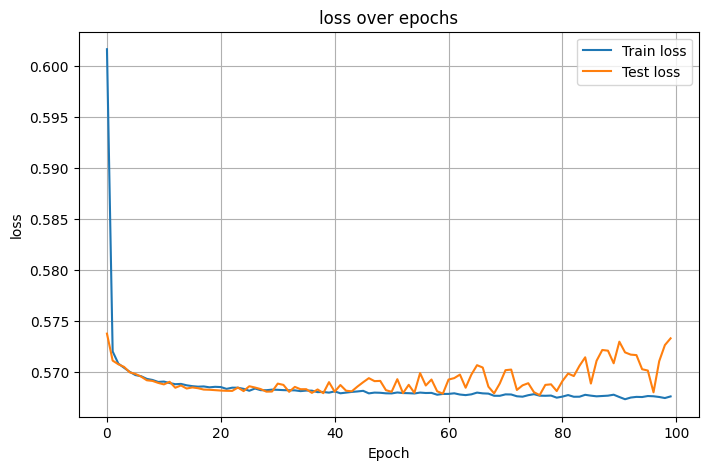

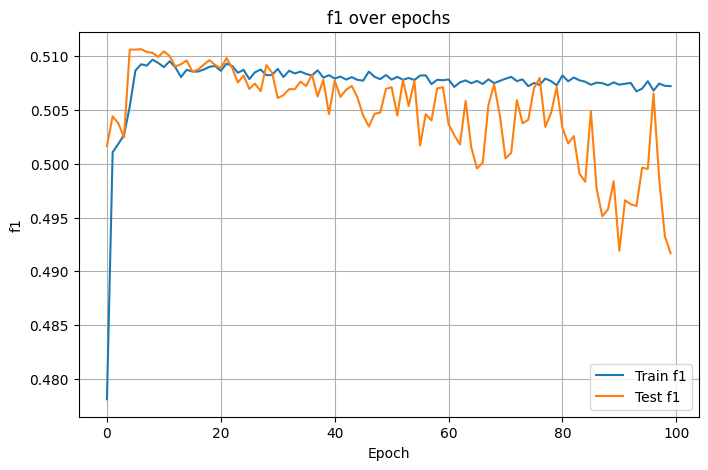

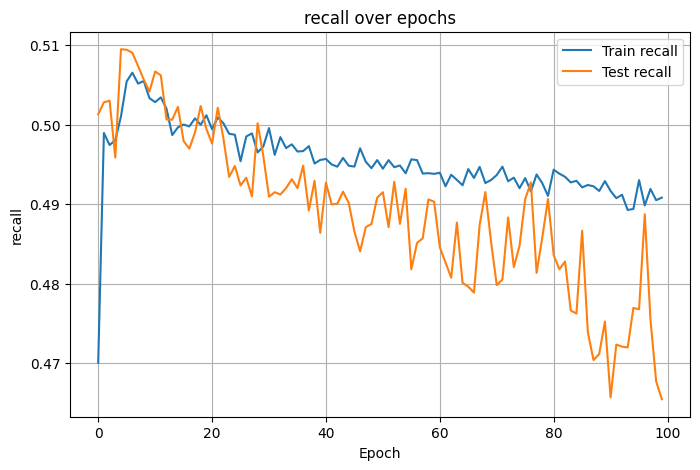

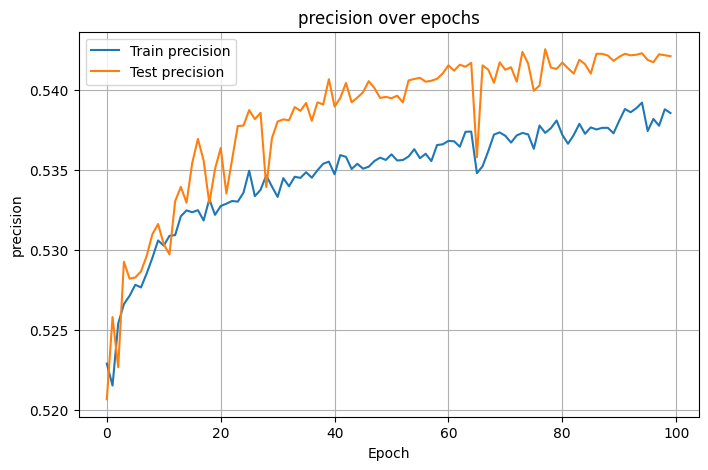

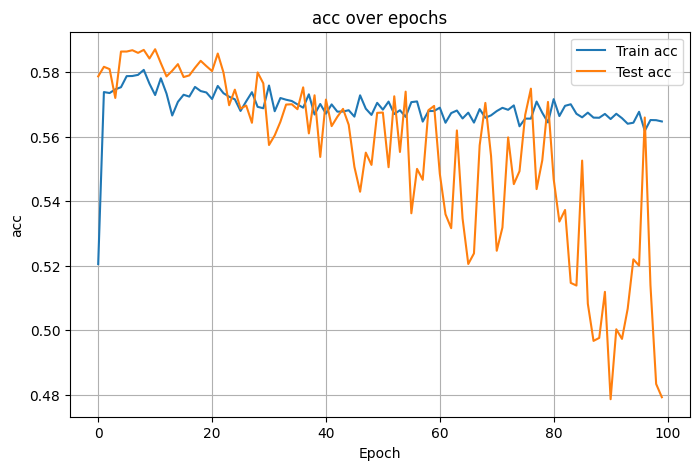

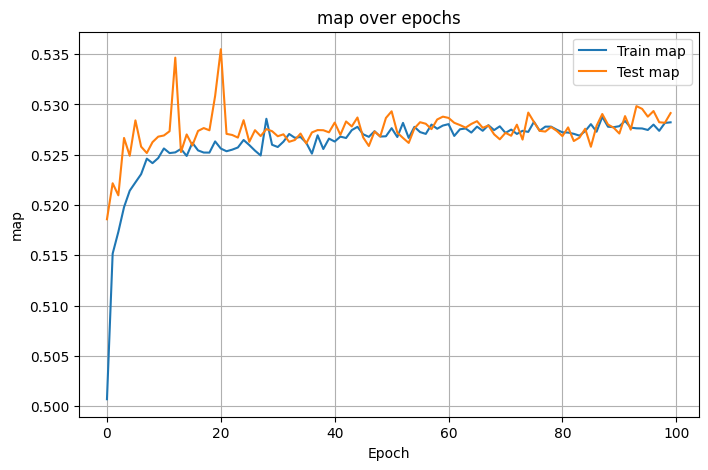

In [100]:
main()